In [143]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt


In [154]:
def simple_exp_smooth(d, extra_periods = 1, alpha = 0.4):

    col_len = len(d)   
    #append np.nan for number of extra periods you want to forecast
    [d.append(np.nan) for i in range(extra_periods)]

    #fill forecast column with nan values
    f = []
    [f.append(np.nan) for i in range(col_len+extra_periods)]

    #inititate forecast column
    f[0] = d[0]

    #forecast historical data
    for i in range(1,col_len+1):
        f[i] = (a*d[i-1] + (1-a)*f[i-1])

    #forecast into the future
    for i in range(extra_periods-1):
        f[i+col_len+1] = ((1-a)*f[i+col_len])


    #map to dataframe
    df = pd.DataFrame.from_dict({"Demand":d, "Forecast":f})
    df['Error'] = df['Forecast'] - df['Demand']
    
    return df


In [149]:
def double_exponential_smooth(d, extra_periods = 1, alpha = 0.4, beta = 0.4):
    #length of input list
    cols = len(d) 
   
    for i in range(extra_periods):
        d.append(np.nan)

    #fill forecast, level, and trend columns with nan
    f = np.array([np.nan]*(cols+extra_periods))
    a = np.array([np.nan]*(cols+extra_periods))
    b = np.array([np.nan]*(cols+extra_periods))

    #initialize level and trend columns
    a[0] = d[0]
    b[0] = d[1]-d[0]
    
    #populate level and trend columns
    for i in range(1,cols):
        a[i] = alpha * d[i] + (1-alpha)*(a[i-1] + b[i-1])
        b[i] = beta * (a[i] - a[i-1]) + (1-beta)*b[i-1]

    #forecast next to historical data
    for i in range(1,cols+1):
        f[i] = a[i-1] + b[i-1]

    #forecast into the future
    for i in range(cols+1, extra_periods + cols):
        f[i] = f[i-1] + b[cols-1]



    df = pd.DataFrame.from_dict({'Demand':d, 'Forecast':f, 'Level':a, 'Trend':b})
    df['Error'] = df['Demand'] - df['Forecast']
    return(df)
    
    

In [144]:
def kpi(df):
    #average demand
    dem_ave = df.loc[df['Error'].notnull(), 'Demand'].mean()
    #absolute bias
    bias_abs = df['Error'].mean()
    #relative bias
    bias_rel = bias_abs / dem_ave
    #print results 
    print('Bias: {:0.2f}, {:.2%}'.format(bias_abs, bias_rel))

    #calculate MAPE
    MAPE = (df['Error'].abs() / df['Demand']).mean()
    #print results
    print('MAPE: {:0.2%}'.format(MAPE))

    #calculate absoltue and scaled MAE
    MAE_abs = df['Error'].abs().mean()
    MAE_rel = MAE_abs / dem_ave
    #print results
    print('MAE: {:0.2f}, {:0.2%}'.format(MAE_abs,MAE_rel))

    #calculate absolute and scaled RSME
    RMSE_abs = np.sqrt((df['Error']**2).mean())
    RMSE_rel =  RMSE_abs / dem_ave
    #print results
    print('RMSE: {:0.2f}, {:0.2%}'.format(RMSE_abs,RMSE_rel))

In [155]:
def exp_smooth_optimization(d, extra_periods = 6):

    params = [] #contains all the different parameter sets
    KPIs = [] #contains the results of each model
    dfs = [] #contains all the DataFrames returned by th different models

    for alpha in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:

        df = simple_exp_smooth(d, extra_periods = extra_periods, alpha = alpha)
        params.append(f'Simple Smoothing, alpha: {alpha}')
        dfs.append(df)
        MAE = df['Error'].abs().mean()
        KPIs.append(MAE)

        for beta in [0.05, 0.1, 0.2, 0.3, 0.4]:

            df = double_exponential_smooth(d, extra_periods = extra_periods, alpha = alpha, beta = beta)
            params.append(f'Double Smoothing, alpha: {alpha}, beta: {beta}')
            dfs.append(df)
            MAE = df['Error'].abs().mean()
            KPIs.append(MAE)

    mini = np.argmin(KPIs)
    print(f'Best solution found for {params[mini]} MAE of', round(KPIs[mini],2))

    return(dfs[mini])
                

    

In [145]:
d = [28,19,18,13,19,16,19,18,13,16,16,11,18,15,13,15,13,11,13,10,12]
table = simple_exp_smooth(d, extra_periods=4, a=0.4)
table

Demand   Forecast     Error
0     28.0  28.000000  0.000000
1     19.0  28.000000  9.000000
2     18.0  24.400000  6.400000
3     13.0  21.840000  8.840000
4     19.0  18.304000 -0.696000
5     16.0  18.582400  2.582400
6     19.0  17.549440 -1.450560
7     18.0  18.129664  0.129664
8     13.0  18.077798  5.077798
9     16.0  16.046679  0.046679
10    16.0  16.028007  0.028007
11    11.0  16.016804  5.016804
12    18.0  14.010083 -3.989917
13    15.0  15.606050  0.606050
14    13.0  15.363630  2.363630
15    15.0  14.418178 -0.581822
16    13.0  14.650907  1.650907
17    11.0  13.990544  2.990544
18    13.0  12.794326 -0.205674
19    10.0  12.876596  2.876596
20    12.0  11.725958 -0.274042
21     NaN  11.835575       NaN
22     NaN   7.101345       NaN
23     NaN   4.260807       NaN
24     NaN   2.556484       NaN

In [151]:
kpi(table)

Bias: 1.92, 12.40%
MAPE: 18.33%
MAE: 2.61, 16.81%
RMSE: 3.80, 24.45%


<AxesSubplot:>

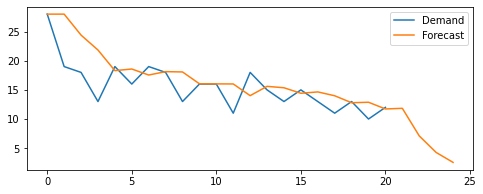

In [152]:
table[['Demand','Forecast']].plot(figsize=(8,3))

In [156]:
output = exp_smooth_optimization(d, extra_periods=6)

Best solution found for Double Smoothing, alpha: 0.6, beta: 0.4 MAE of 3.63
